## EDA and Preprocessing

In [1]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import os
import numpy as np

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

In [77]:
df_app=pd.read_csv("final_app_details.csv",sep="\t")

In [78]:
app_rev=pd.read_csv("final_app_reviews.csv",sep="\t",error_bad_lines=False)

In [6]:
len(df_app)

6839

In [7]:
len(app_rev)

552823

In [8]:
df_app.head()

,app_id,app_title,rating,price,no_of_ratings,size,in_app_products,installs,ratings_distribution_5,ratings_distribution_4,ratings_distribution_3,ratings_distribution_2,ratings_distribution_1,is_editors_choice,genre,age_rating,app_url
0,com.aaa.android.discounts,AAA Mobile,4.1,0,"26,274",48M,NaN,"1,000,000+","15,408","5,053","1,653","1,055","3,114",0,Lifestyle,Everyone,https://play.google.com/store/apps/details?id=...
1,se.chai.vrtv.free,VRTV VR Video Player Free,4.0,0,"1,832",15M,NaN,"100,000+","1,031",342,169,77,214,0,Video Players & Editors,Everyone,https://play.google.com/store/apps/details?id=...
2,com.bindasapp.RangEHinaUrduNovel,Rang E Hina Urdu Romantic Novel,4.5,0,4,7.6M,NaN,"1,000+",2,2,0,0,0,0,Books & Reference,Everyone,https://play.google.com/store/apps/details?id=...
3,questionlogix.logomakerfree,Logo Maker Free,4.0,0,"3,392",38M,NaN,"1,000,000+","2,206",271,251,95,589,0,Business,Everyone,https://play.google.com/store/apps/details?id=...
4,com.gamesking.truckdriver,Indian Cargo Truck,4.0,0,78,56M,NaN,"10,000+",52,3,10,4,10,0,Simulation,Everyone,https://play.google.com/store/apps/details?id=...


In [9]:
df_app.dtypes

app_id                     object
app_title                  object
rating                    float64
price                      object
no_of_ratings              object
size                       object
in_app_products            object
installs                   object
ratings_distribution_5     object
ratings_distribution_4     object
ratings_distribution_3     object
ratings_distribution_2     object
ratings_distribution_1     object
is_editors_choice           int64
genre                      object
age_rating                 object
app_url                    object
dtype: object

In [79]:
del df_app['in_app_products']

In [80]:
#Dropping Data frame which has NAN values
df_app=df_app.dropna()
print("The Google play store dataset contains %d rows and %d columns after dropping NAN." %(df_app.shape[0],df_app.shape[1]))

The Google play store dataset contains 5525 rows and 16 columns after dropping NAN.


In [81]:
df_app.duplicated(subset='app_id').value_counts()

False    5525
dtype: int64

In [82]:
df_app.shape

(5525, 16)

In [83]:
df_app['category']=df_app['genre']

In [84]:
#Converting the Installs column into integer
df_app['installs']=df_app['installs'].apply(lambda a:a.split('+')[0])   #Removes '+' from Installs
se=df_app['installs'].apply(lambda a:a.split(','))                      #Removes ',' from Installs 

def add_list(x):
    sum=' '
    for i in range(0,len(x)):
        sum+=x[i]
    return int(sum)  

df_app['installs']=se.apply(lambda a:add_list(a))                      #Convert str to int values 
df_app.head(5)

,app_id,app_title,rating,price,no_of_ratings,size,installs,ratings_distribution_5,ratings_distribution_4,ratings_distribution_3,ratings_distribution_2,ratings_distribution_1,is_editors_choice,genre,age_rating,app_url,category
0,com.aaa.android.discounts,AAA Mobile,4.1,0,"26,274",48M,1000000,"15,408","5,053","1,653","1,055","3,114",0,Lifestyle,Everyone,https://play.google.com/store/apps/details?id=...,Lifestyle
1,se.chai.vrtv.free,VRTV VR Video Player Free,4.0,0,"1,832",15M,100000,"1,031",342,169,77,214,0,Video Players & Editors,Everyone,https://play.google.com/store/apps/details?id=...,Video Players & Editors
2,com.bindasapp.RangEHinaUrduNovel,Rang E Hina Urdu Romantic Novel,4.5,0,4,7.6M,1000,2,2,0,0,0,0,Books & Reference,Everyone,https://play.google.com/store/apps/details?id=...,Books & Reference
3,questionlogix.logomakerfree,Logo Maker Free,4.0,0,"3,392",38M,1000000,"2,206",271,251,95,589,0,Business,Everyone,https://play.google.com/store/apps/details?id=...,Business
4,com.gamesking.truckdriver,Indian Cargo Truck,4.0,0,78,56M,10000,52,3,10,4,10,0,Simulation,Everyone,https://play.google.com/store/apps/details?id=...,Simulation


In [85]:
#Removing Currency symbol from the Price and making it float
def remove_curr(x):
    if x !='0':
        x=x.split('$')[1]
    return float(x)   

df_app['price']=df_app['price'].apply(lambda a:remove_curr(a))  #Removes '$' from Price
df_app.head(5)

,app_id,app_title,rating,price,no_of_ratings,size,installs,ratings_distribution_5,ratings_distribution_4,ratings_distribution_3,ratings_distribution_2,ratings_distribution_1,is_editors_choice,genre,age_rating,app_url,category
0,com.aaa.android.discounts,AAA Mobile,4.1,0.0,"26,274",48M,1000000,"15,408","5,053","1,653","1,055","3,114",0,Lifestyle,Everyone,https://play.google.com/store/apps/details?id=...,Lifestyle
1,se.chai.vrtv.free,VRTV VR Video Player Free,4.0,0.0,"1,832",15M,100000,"1,031",342,169,77,214,0,Video Players & Editors,Everyone,https://play.google.com/store/apps/details?id=...,Video Players & Editors
2,com.bindasapp.RangEHinaUrduNovel,Rang E Hina Urdu Romantic Novel,4.5,0.0,4,7.6M,1000,2,2,0,0,0,0,Books & Reference,Everyone,https://play.google.com/store/apps/details?id=...,Books & Reference
3,questionlogix.logomakerfree,Logo Maker Free,4.0,0.0,"3,392",38M,1000000,"2,206",271,251,95,589,0,Business,Everyone,https://play.google.com/store/apps/details?id=...,Business
4,com.gamesking.truckdriver,Indian Cargo Truck,4.0,0.0,78,56M,10000,52,3,10,4,10,0,Simulation,Everyone,https://play.google.com/store/apps/details?id=...,Simulation


Text(0.5,1,'Number of Apps available based on Category')

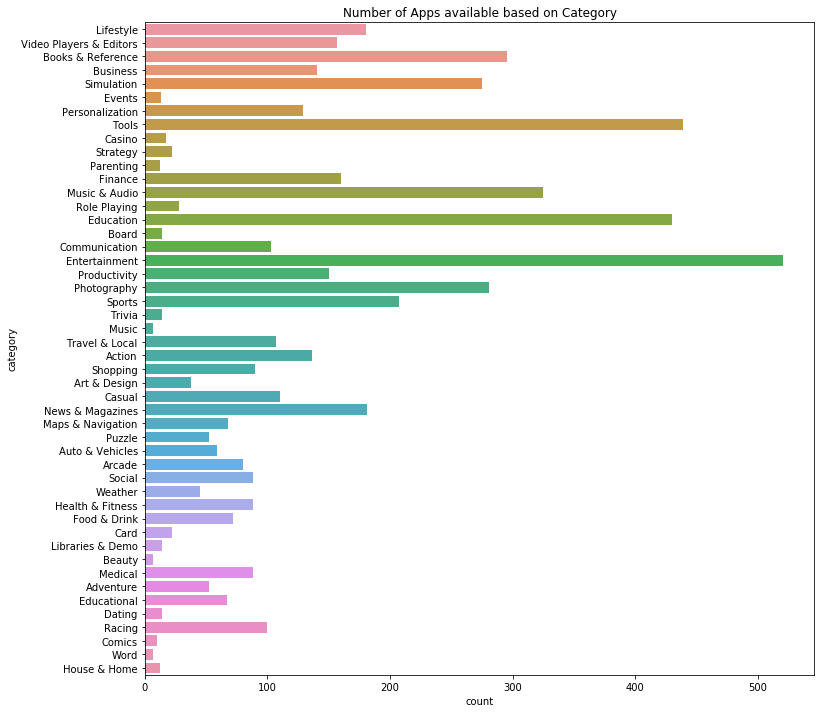

In [86]:
#Checking the number of Apps available on playstore based on category
plt.figure(figsize=(12,12))
sns.countplot(y='category',data=df_app)
plt.title("Number of Apps available based on Category")

Text(0.5,1,'Number of Apps installed based on Category')

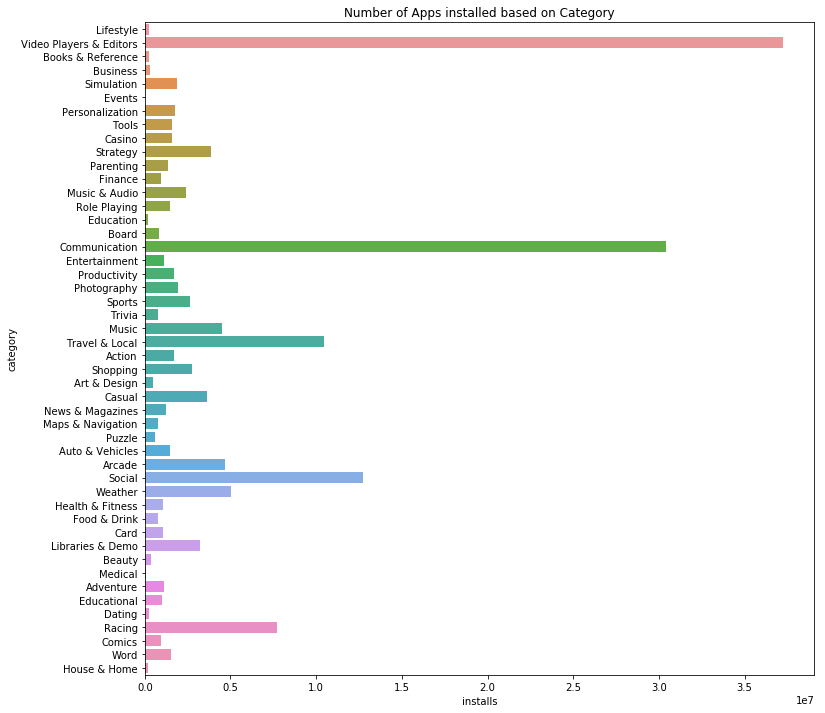

In [87]:
#Most installed apps based on Category
plt.figure(figsize=(12,12))
sns.barplot(x='installs',y='category',data=df_app,ci=None)
plt.title("Number of Apps installed based on Category")

Text(0.5,1,'Number of Apps available based on Content rating')

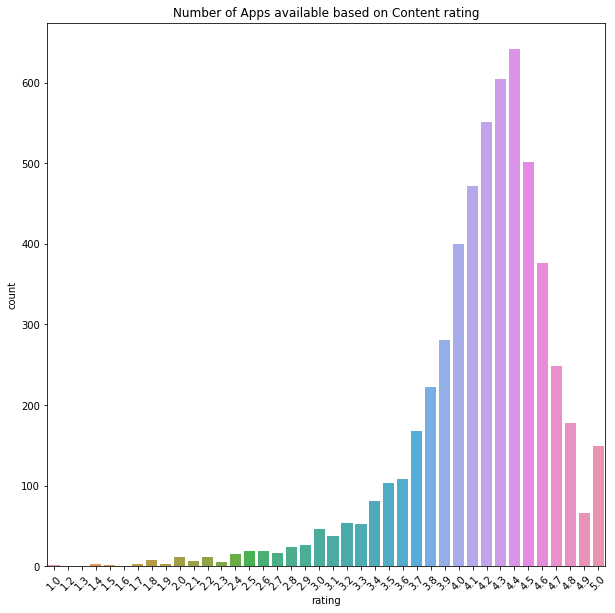

In [88]:
#Apps available based on Content rating
plt.figure(figsize=(10,10))
sns.countplot(x='rating',data=df_app,)
plt.xticks(rotation=45)
plt.title("Number of Apps available based on Content rating")

In [89]:
df_app.dtypes

app_id                     object
app_title                  object
rating                    float64
price                     float64
no_of_ratings              object
size                       object
installs                    int64
ratings_distribution_5     object
ratings_distribution_4     object
ratings_distribution_3     object
ratings_distribution_2     object
ratings_distribution_1     object
is_editors_choice           int64
genre                      object
age_rating                 object
app_url                    object
category                   object
dtype: object

In [90]:
del df_app['genre']

In [91]:
df_app['app_type'] = np.where(df_app['price']==0, 'Free', 'Paid')

In [92]:
df_app.head()

,app_id,app_title,rating,price,no_of_ratings,size,installs,ratings_distribution_5,ratings_distribution_4,ratings_distribution_3,ratings_distribution_2,ratings_distribution_1,is_editors_choice,age_rating,app_url,category,app_type
0,com.aaa.android.discounts,AAA Mobile,4.1,0.0,"26,274",48M,1000000,"15,408","5,053","1,653","1,055","3,114",0,Everyone,https://play.google.com/store/apps/details?id=...,Lifestyle,Free
1,se.chai.vrtv.free,VRTV VR Video Player Free,4.0,0.0,"1,832",15M,100000,"1,031",342,169,77,214,0,Everyone,https://play.google.com/store/apps/details?id=...,Video Players & Editors,Free
2,com.bindasapp.RangEHinaUrduNovel,Rang E Hina Urdu Romantic Novel,4.5,0.0,4,7.6M,1000,2,2,0,0,0,0,Everyone,https://play.google.com/store/apps/details?id=...,Books & Reference,Free
3,questionlogix.logomakerfree,Logo Maker Free,4.0,0.0,"3,392",38M,1000000,"2,206",271,251,95,589,0,Everyone,https://play.google.com/store/apps/details?id=...,Business,Free
4,com.gamesking.truckdriver,Indian Cargo Truck,4.0,0.0,78,56M,10000,52,3,10,4,10,0,Everyone,https://play.google.com/store/apps/details?id=...,Simulation,Free


In [94]:
df_app['app_type'].value_counts()

Free    5409
Paid     116
Name: app_type, dtype: int64

Total number of apps available and installed

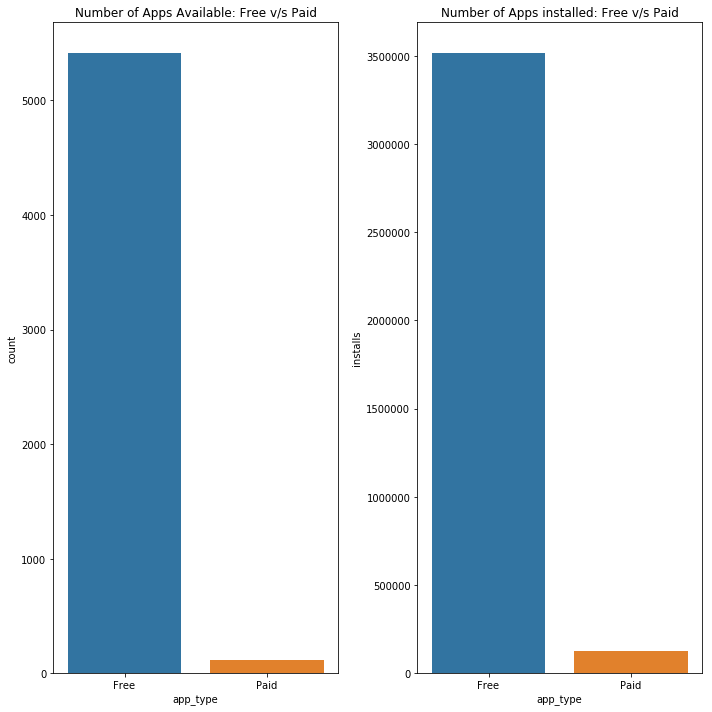

In [95]:
#Number of free and paid Apps available
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sns.countplot(x='app_type',data=df_app)
plt.title("Number of Apps Available: Free v/s Paid")

#Most installed apps based on Category
plt.subplot(1,2,2)
sns.barplot(x='app_type',y='installs',data=df_app,ci=None)
plt.title("Number of Apps installed: Free v/s Paid")
plt.tight_layout()

Text(0.5,1,'Number of Apps and ratings ')

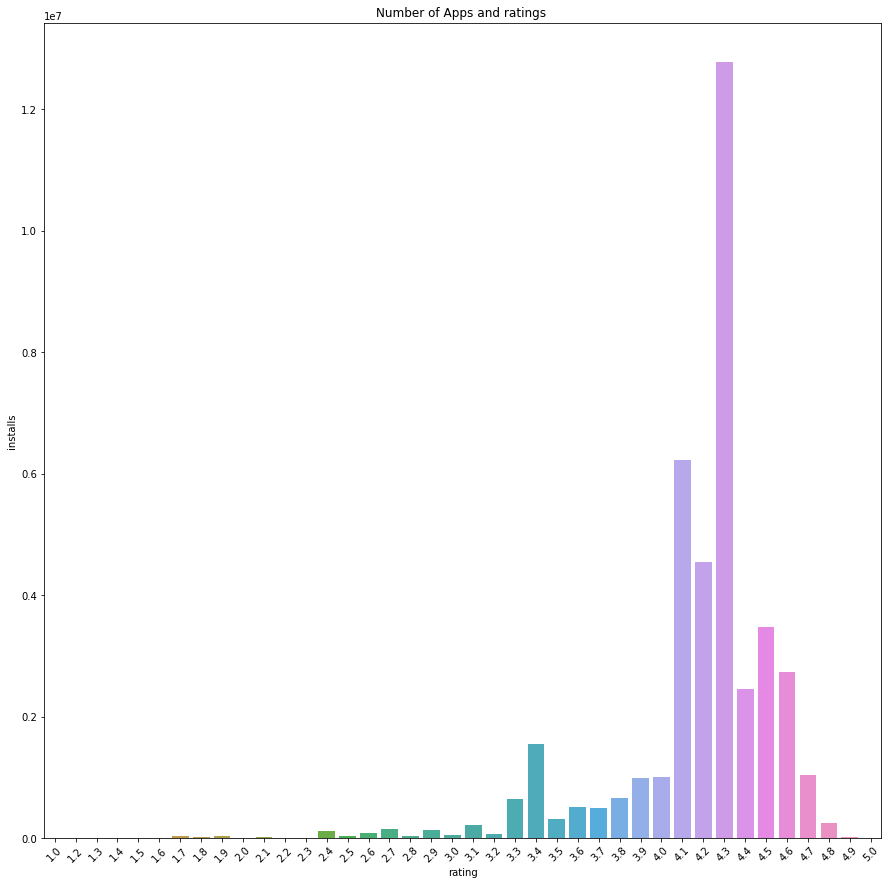

In [96]:
#Ratings of Apps and the number of installed
plt.figure(figsize=(15,15))
sns.barplot(y='installs',x='rating',data=df_app,ci=None)
plt.xticks(rotation=45)
plt.title("Number of Apps and ratings ")

In [97]:
import statsmodels.formula.api as sm
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.cross_validation import train_test_split

In [98]:
df_app['installs_new']=str(df_app['installs'])

In [99]:
df_app['installs'].value_counts()

100000        1155
1000000        890
10000          877
1000           512
500000         450
50000          433
5000           320
10000000       253
5000000        215
100            169
500            130
10              31
50000000        31
50              30
100000000       21
1000000000       4
500000000        3
5000000000       1
Name: installs, dtype: int64

In [101]:
#Define popularity metric
df_app['popularity'] = np.where(df_app['installs'] >= 5000000, 'Very High', 
                      np.where(df_app['installs'] >= 100000,
                               'High', np.where(df_app['installs'] >= 5000,
                               'Medium', 'Low')))

In [102]:
df_app['popularity'].value_counts()

High         2495
Medium       1630
Low           872
Very High     528
Name: popularity, dtype: int64

In [104]:
del df_app['installs_new']